In [4]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

In [5]:
input_file=codecs.open('socialmedia_relevant_cols.csv','r',encoding='utf-8',errors='replace')
output_file=open('socialmedia_relevant_cols_clean.csv','w',encoding='utf-8')
def sanitize_characters(raw,clean):
    for line in input_file:
        out=line
        output_file.write(line)
sanitize_characters(input_file, output_file)
        
        

In [6]:
questions=pd.read_csv('socialmedia_relevant_cols_clean.csv')
questions.columns=['text','choose_one','class_label']
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [7]:
questions.describe()

,class_label
count,10813.000000
mean,0.431610
std,0.498302
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [8]:
def standardize_text(df,text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df
questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [9]:
clean_questions=pd.read_csv('clean_data.csv')
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10808,10808,300k exotic car wrecked in train accident \r\n,Relevant,1
10809,10809,the twins pitcher's ego is now wrecked,Not Relevant,0
10810,10810,lol u got wrecked,Not Relevant,0
10811,10811,you wrecked my whole world,Not Relevant,0
10812,10812,i wrecked my stomach help,Not Relevant,0


In [10]:
clean_questions.groupby('class_label').count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6162,6162,6162
1,4635,4635,4635
2,16,16,16


In [11]:
from nltk.tokenize import RegexpTokenizer

In [12]:
tokenizer=RegexpTokenizer(r"\w+")
clean_questions['tokens']=clean_questions['text'].apply(tokenizer.tokenize)
clean_questions.head()


,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
all_words=[word for tokens in clean_questions['tokens'] for word in tokens]
sentence_lengths=[len(tokens) for tokens in clean_questions['tokens']]
VOCAB=sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

153895 words total, with a vocabulary size of 18065
Max sentence length is 34


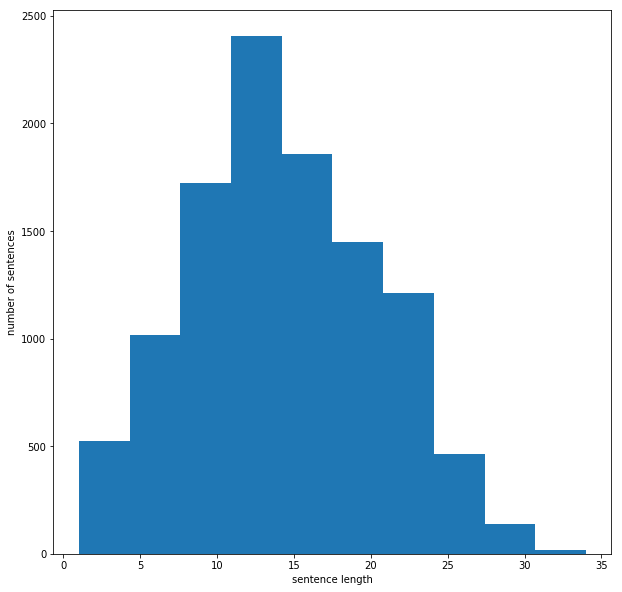

In [14]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,10))
plt.xlabel('sentence length')
plt.ylabel('number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [16]:
def cv(data):
    count_vectorizer=CountVectorizer()
    emb=count_vectorizer.fit_transform(data)
    return emb,count_vectorizer
list_corpus=clean_questions['text'].tolist()
list_labels=clean_questions['class_label'].tolist()
X_train,X_test,y_train,y_test=train_test_split(list_corpus,list_labels,test_size=0.2,random_state=40)
X_train_counts,count_vectorizer=cv(X_train)
X_test_counts=count_vectorizer.transform(X_test)


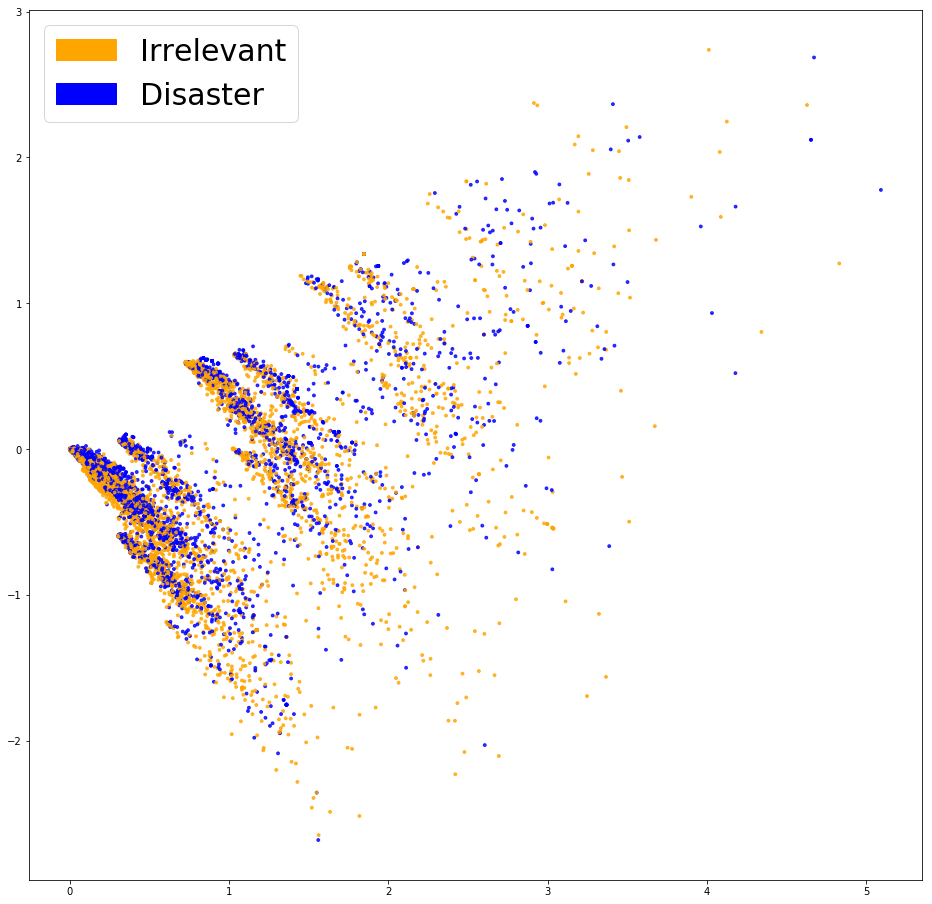

In [17]:
from sklearn.decomposition import PCA,TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
def plot_LSA(test_data,test_labels,savepath='PCA_demo.csv',plot=True):
    lsa=TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores=lsa.transform(test_data)
    color_mapper={label:idx for idx,label in enumerate(set(test_labels))}
    color_column=[color_mapper[label] for label in test_labels]
    colors=['orange','blue','blue']
    if plot:
        plt.scatter(lsa_scores[:,0],lsa_scores[:,1],s=8,alpha=0.8,c=test_labels,cmap=matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='Irrelevant')
        green_patch = mpatches.Patch(color='blue', label='Disaster')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 30})
fig=plt.figure(figsize=(16,16))
plot_LSA(X_train_counts,y_train)
plt.show()

In [18]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C=30.0,class_weight='balanced',solver='newton-cg',multi_class='multinomial',n_jobs=-1,random_state=40)
clf.fit(X_train_counts,y_train)
y_predicted_counts=clf.predict(X_test_counts)

In [19]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report
def get_metrics(y_test,y_predicted):
    precision=precision_score(y_test,y_predicted,pos_label=None,average='weighted')
    recall=recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    f1=f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    accuracy=accuracy_score(y_test,y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.758, precision = 0.758, recall = 0.758, f1 = 0.758


In [20]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt


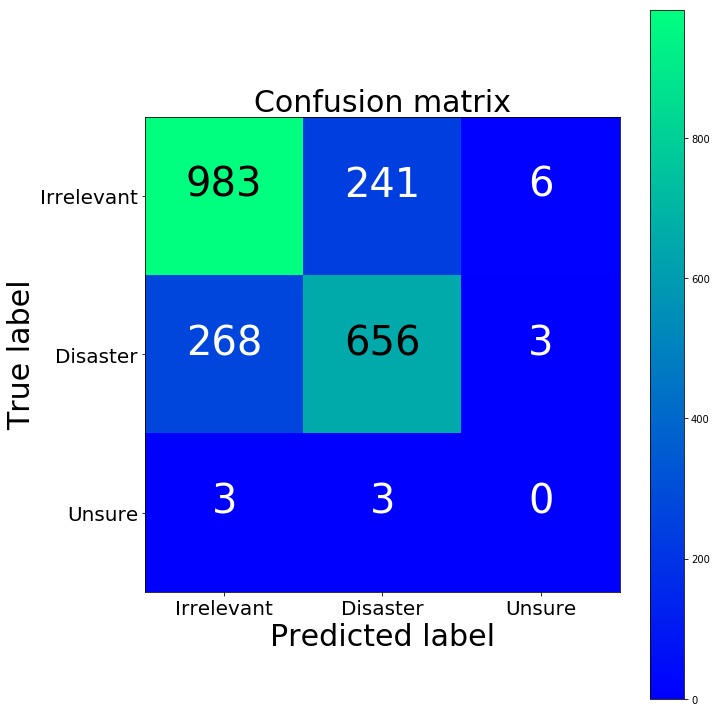

[[983 241   6]
 [268 656   3]
 [  3   3   0]]


In [21]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [22]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)
        
        

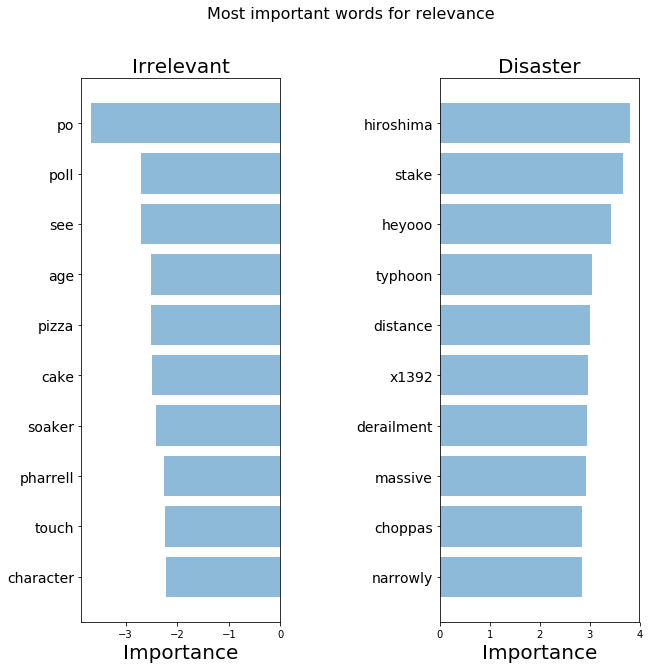

In [23]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [24]:
import gensim

In [25]:
word2vec_path='GoogleNews-vectors-negative300.bin.gz'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

FileNotFoundError: [Errno 2] No such file or directory: 'GoogleNews-vectors-negative300.bin.gz'

In [26]:
def get_average_word2vec(tokens_list,vector,generate_missing=False,k=300):
    if len(tokens_list) <1:
        return np.zeros(k)
    if generate_missing:
        vectorized=[vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized=[vector[word] if word in vector in vector else np.zeros(k) for word in tokens_list]
    length=len(vectorized,axis=0)
    summed=np.sum(vectorized,axis=0)
    averaged=np.divide(summed,length)
    return averaged
def get_word2vec_embeddings(vectors,clean_questions,generate_missing=False):
    embeddigns=clean_questions['tokens'].apply(lambda x:get_average_word(x,vectors,generate_missing=generate_missing))
    return list(embeddings)
embeddings=get_word2vec_embeddigns(word2vec,clean_questions)
X_train_word2vec,X_test_word2vec,y_train_word2vec,y_test_word2vec=train_test_split(embeddings,list_labels,test_size=0.2,random_state=40)


fig=plt.figure(figsize=(16,16))
plot_LSA(embeddings,list_labels)
plt.show()
                                               

NameError: name 'get_word2vec_embeddigns' is not defined

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
EMBEDDING_DIM=300
MAX_SEQUENCE_LENGTH=35
VOCAB_SIZE=len(VOCAB)
VALIDATION_SPLIT=0.2
tokenizer=Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions['text'].tolist())
sequences=tokenizer.texts_to_sequences(clean_questions['text'].tolist())
word_index=tokenizer.word_index
print('found %s unique tokens.' % len(word_index))
cnn_data=pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)
labels=to_categorical(np.asarray(clean_questions['class_label']))
indices=np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data=cnn_data[indices]
labels=labels[indices]
num_validation_samples=int(VALIDATION_SPLIT * cnn_data.shape[0])
embedding_weights=np.zeros((len(word_index)+1,EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:]=word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape()) 
                                                                                      
    

found 19062 unique tokens.


NameError: name 'word2vec' is not defined

In [ ]:
from keras.layers import Dense,Input,Flatten,Dropout,Merge
from keras.layers import Conv1D,MaxPooling1D,Embedding
from keras.layers import LSTM,Bidirectional
from keras.models import Model

def ConvNet(embeddings,max_sequence_length,num_words,embedding_dim,labels_index,trainable=False,extra_conv=True):
    embedding_layers=Embedding(num_words,
                              embedding_num,
                              weights=[embeddings],
                               input_length-max_sequence_length,
                               trainable=trainable
                            
                              )
    sequence_input=Input(shape=(max_sequence_length,),dtype='int32')
    embedded_sequences=embedding_layers(sequence_input)
    convs=[]
    filter_sizes=[3,4,5]
    for filter_size in filter_sizes:
        1_conv=Conv1D(filters=128,kernel_size=filter_size,activation='relu')(embedded_sequences)
        1_pool=MaxPooling(pool_size=3)(1_conv)
        convs.append(1_pool)
    1_merge=Merge(mode='concat',concat_axis=1)(convs)
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)
    if extra_conv==True:
        x=Dropout(0.5)(1_merge)
    else:
        x=Dropout(0.5)(pool)
    x=Flatten()(x)
    x=Dense(128,activation='relu')(x)
    preds=Dense(labels_index,activation='softmax')(x)
    model=Model(sequence_input,preds)
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return model
    
